In [1]:
import time
print(time.ctime())
%load_ext ipydex.displaytools
%matplotlib inline

Tue Dec  5 15:00:02 2017


In [2]:
import os
os.environ["SYMPY_CACHE_SIZE"] = "10000"

### Betrachtetes System: Balance-Brett

￼ <img src="files/images/balance_brett_skizze2.png">

### Inhalt
* Herleitung der Modellgleichungen in partiell linearisierter Form

### Notwendige Pakete

* `pip install ipydex`
* `pip install symbtools`

### Siehe auch

https://github.com/cknoll/beispiele/blob/master/readme.md



[//]: # (custom_config_start)
$$
\newcommand{\d}{\mathrm{d}}
\newcommand{\col}{\mathrm{col}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
\newcommand{\ddt}{\tfrac{d}{dt}}
$$
[//]: # (custom_config_end)

In [3]:
import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import pickle
import numpy as np
import scipy as sc
import scipy.interpolate
from scipy.integrate import odeint
import matplotlib.pyplot as pl

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct

# switch off warnings 
st.warnings.simplefilter("ignore")

zip0 = st.zip0
printing.init_printing(1)

In [4]:
t = sp.Symbol('t')
Np = 2  # 2 passive Freiheitsgrade
Nq = 1  # 1 aktiver Freiheitsgrad
n = Np + Nq
x = st.symb_vector("x1,x3,x2")

ttheta = x ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

---


---


---


In [5]:
#params = sp.symbols("mC x_sc y_sc Ic mB x_sb y_sb Ib mP x_sp y_sp IP r db dp g", positive=True)
params = sp.symbols("m1 x_s1 y_s1 I1 m2 x_s2 y_s2 I2 m3 x_s3 y_s3 I3 r db dp g cB cZ", positive=True)
st.make_global(params)

tau1, tau2, tau3 = ttau = sp.symbols("tau1, tau2, tau3")  # Eingänge (dienen später auch zur Einführung der Reibung)

### Festlegung der Geometrie des mechanischen Systemes

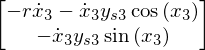

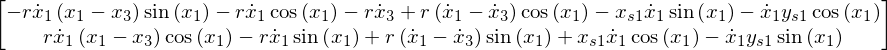

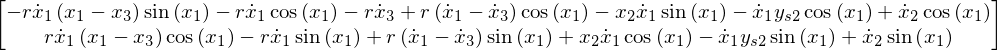

---


In [6]:
#Einheitsvektoren
ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])

# Rotationsmatrix um z-Achse (aus der Bildebene heraus)
Rz = mt.Rz

# Koordinaten der Schwerpunkte und Gelenke

# Nomenklatur-Zuordnung:
# x1: psi
# x2: gamma
# x3: theta

s0 = sp.Matrix([-r*x3, 0]) # Mittelpunkt Zylinder
x_s3 = 0
s3 = s0 + Rz(x3)*(x_s3*ex + y_s3*ey) # Schwerpunkt Zylinder

# Berührungspunkt: Brett-Zylinder
B = s0 + Rz(x1) * r*ey

# Mittelpunkt Brett
# (Annahme: Anfangszustand (x1=x3=0): B0=B
# Punkte differieren nur durch Abrollen
B0 = B + Rz(x1)*ex*r*(x1 - x3)
s1 = B0 + Rz(x1)*(ex*x_s1 + ey*y_s1)# Schwerpunkt Brett

s2 = B0 + Rz(x1)*(ex*x2 + ey*y_s2)# Schwerpunkt Schlitten 


# Zeitableitungen der Schwerpunktskoordinaten
s3d, s1d, s2d = st.col_split(st.time_deriv(st.col_stack(s3, s1, s2), ttheta)) ##

In [7]:
# Energie
T_rot = (I3*xdot3**2 + I1*xdot1**2 + I2*xdot1**2)/2
T_trans = (m3*s3d.T*s3d  +  m1*s1d.T*s1d + m2*s2d.T*s2d)/2
T = T_rot + T_trans[0]

V = m3*g*s3[1] + m1*g*s1[1] + m2*g*s2[1]

In [8]:
# Leite Bewegungsgleichungen her
tau1 = -cB*tthetad[0]
#tau2 = F
tau3 = -cZ*tthetad[1]
%time mod = mt.generate_symbolic_model(T, V, ttheta, [tau1, tau3, tau2]) # tau1 = -cB*x4, tau2 = F, tau3 = -cZ*x6

Wall time: 35.7 s


In [ ]:
# LaTeX ausschalten (Platz sparen)
#printing.init_printing(0)

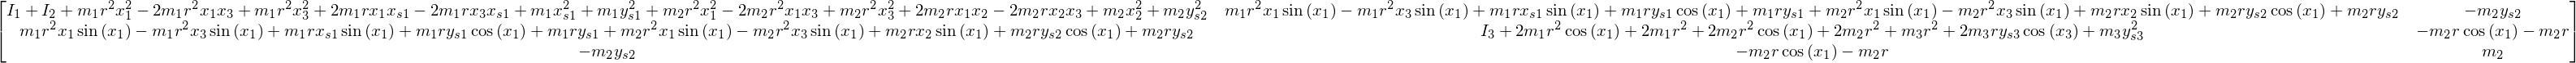

In [10]:
# zeige Massematrix
mod.MM 

### Bestimmung der Zustandsraumdarstellungen

In [11]:
# dauert ggf. ein paar Minuten
%time mod.calc_state_eq(simplify=True)
#%time mod.calc_state_eq(simplify=False)

Wall time: 44min 4s


In [12]:
mod.f.free_symbols

In [13]:
%time mod.calc_coll_part_lin_state_eq(simplify=True)
#%time mod.calc_coll_part_lin_state_eq(simplify=False)

Wall time: 22min 5s


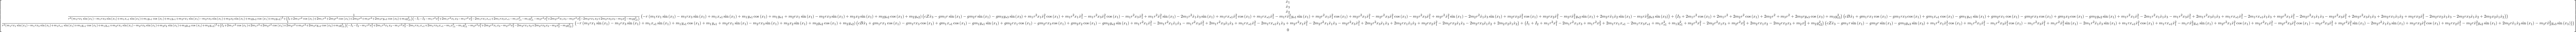

In [14]:
# Vektorfeld f
mod.ff

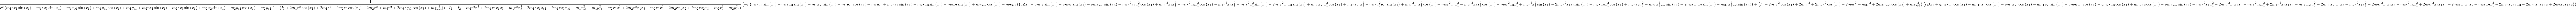

In [15]:
mod.ff[3]

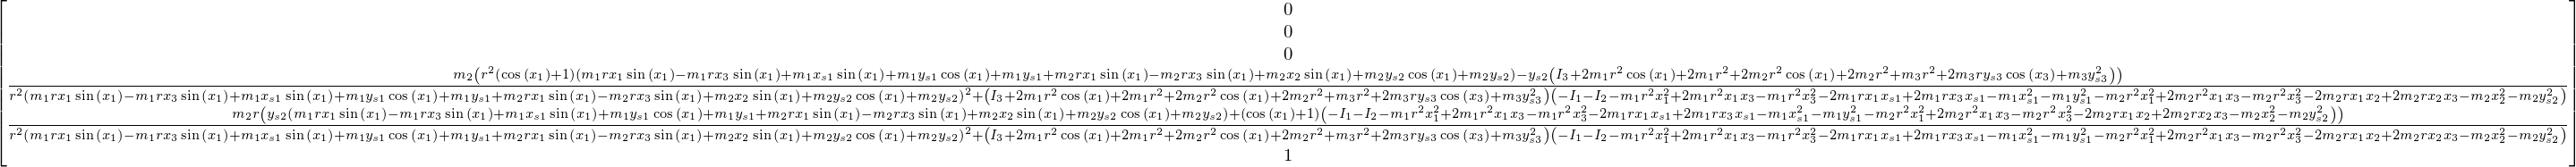

In [16]:
# Vektorfeld g
mod.gg

In [17]:
import pickle
with open("bal_board.pkl", "bw") as f:
    pickle.dump([mod, params], f)

In [18]:
A = sc.column_stack([mod.f.diff(xi) for xi in mod.x]) ##:

A := array([[0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
            [ (m2*(r**2*(cos(x1) + 1)*(m1*r*x1*sin(x1) - m1*r*x3*sin(x1) + m1*x_s1*sin(x1) + m1*y_s1*cos(x1) + m1*y_s1 + m2*r*x1*sin(x1) - m2*r*x3*sin(x1) + m2*x2*sin(x1) + m2*y_s2*cos(x1) + m2*y_s2) - y_s2*(I3 + 2*m1*r**2*cos(x1) + 2*m1*r**2 + 2*m2*r**2*cos(x1) + 2*m2*r**2 + m3*r**2 + 2*m3*r*y_s3*cos(x3) + m3*y_s3**2))*(g*sin(x1) - r*x1*xdot1**2 + r*x3*xdot1**2 - x2*xdot1**2) + r*(m1*r*x1*sin(x1) - m1*r*x3*sin(x1) + m1*x_s1*sin(x1) + m1*y_s1*cos(x1) + m1*y_s1 + m2*r*x1*sin(x1) - m2*r*x3*sin(x1) + m2*x2*sin(x1))*(cZ*xdot3 - g*m1*r*sin(x1) - g*m2*r*sin(x1) - g*m3*y_s3*sin(x3) + m1*r**2*x1*xdot1**2*cos(x1) + m1*r**2*x1*xdot1**2 - m1*r**2*x3*xdot1**2*cos(x1) - m1*r**2*x3*xdot1**2 + m1*r**2*xdot1**2*sin(x1) - 2*m1*r**2*xdot1*xdot3*sin(x1) + m1*r*x_s1*xdot1**2*cos(x1) + m1*r*x_s1*xdot1**2 - m1*r*xdot1**2*y_s1*sin(x1) + m2*r**2*x1*xdot1**2*cos(x1) + m2*r**2*x1*xdot1**2 - m2*r**2*x3*xdot1**2*cos(x1

---
